#Data 620 - Larger Two-Mode Network

##Project 2: Graphing Movies and Actors

##Group 6: Alice Friedman, Stephen Jones, Jeffrey Littlejohn, Jun Pan

##Due: 6/22/19

###Assignment Detail:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?

###Networks in Film: Actors and Movies

That there are six degrees of separation between the actor Kevin Bacon and anyone involved with the Hollywood film industry may be the first bit of network theory that most people learn. Marilyn Monroe, you ask? She was in Let's Make It Legal with Robert Wagner, who played a lawyer in the trashy but fun 1998 movie Wild Things. That's three steps, or nodes, between the actors. Monroe-movie-Wagner-movie-Bacon. 

This bit of movie trivia is often then expanded to imply that there are six degrees of separation between any two people on earth. We're sticking with movies for this project.

###The Dataset: Kaggle TMBD

The [Internet Movie Database (IMDB)](https://www.imdb.com/) has been the extremely well-known and useful repository of movie information since the 1990s. IMDB makes much of their data availabe on their website via compressed files in a format resemembling relational database tables. Searches revealed a number of IMDB datasets out there formatted specifically for graph analysis, including [this giant dataset](http://networkrepository.com/IMDB.php) that features almost 900k nodes and 4m edges but no labels. Besides, we probably don't want to pick up a late-night Cinemax movie or a silent 1957 French movie that three people have seen, either of which will surely have a robust IMDB entry.

Most curated IMDB sets have a limitation that affects our purposes - they tend to only include "principal" actors. Some only include the top 3 billed on a film. We looked at downloading [source files from IMDB](https://www.imdb.com/interfaces/). Due to size and data integrity issues, attempts to import multiple 10m+ row tab-delimited text files to Microsoft SQL Server via SQL Server Integtration Services (SSIS), MySQL via manual load, and Python itself all failed.

We will utilize a [Kaggle dataset of movie data](https://www.kaggle.com/PromptCloudHQ/imdb-data/downloads/imdb-data-from-2006-to-2016.zip/1) that uses IMDB as its source. It's limited to the 1000 most popular movies made from 2006-2016 at the time of the author's data pull. 

The dataset does include cast information beyond just the top 3 billed actors. However, it is limited to major cast members. Ignoring the time differences, we will miss early career appearnces such as Renee Zellwegger in the background of the pool hall in Dazed and Confused or Tom Hardy and the actor who plays Jamie Lannister in Game of Thrones in small roles in Black Hawk Down.

###Our Questions

We will calculate multiple metrics for our bipartite graph data of actors and movies. Who will show up with the most betweenness centrality - and thus be a great connector for the Kevin Bacon challenge? Would it be a leading woman or man who crosses genres, or a continuously working character actor who plays in a few different movies a year? Will groups of actors who tend to work with the same directors like the Coen brothers, Tarantino, or Wes Andersen show up as islands?

In [1]:
# Import modules
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import io
import requests
from scipy import stats
from pylab import rcParams
import math
%matplotlib inline

###Data and Graphs

The Kaggle TMDB dataset is provided as a csv, which we will load into pandas as a dataframe. We will manipulate the dataset to show one row per movie-actor combo, a compound primary key. In other words, a movie will be repeated for every actor in it - that we have in our dataset.

In [2]:
#read csv into pandas as a dataframe(df)
url="https://raw.githubusercontent.com/littlejohnjeff/Data_620_Summer_2019/master/IMDB-Movie-Data.csv"
s=requests.get(url).content
imdb=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
#preview our df
imdb.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


A primary purpose of the creation of this dataset is to gauge the box office and critical success of the films. For our exercise, we don't care about this. The current dataset as read into Python return one row per movie with a comma-delimited list of major actors along with other data. 

We want one row/record per Title/individual actor combination. Let's make that happen.

In [4]:
#drop unused columns
imdb = imdb[['Title','Actors']]
imdb.head(15)

,Title,Actors
0,Guardians of the Galaxy,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S..."
1,Prometheus,"Noomi Rapace, Logan Marshall-Green, Michael Fa..."
2,Split,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar..."
3,Sing,"Matthew McConaughey,Reese Witherspoon, Seth Ma..."
4,Suicide Squad,"Will Smith, Jared Leto, Margot Robbie, Viola D..."
5,The Great Wall,"Matt Damon, Tian Jing, Willem Dafoe, Andy Lau"
6,La La Land,"Ryan Gosling, Emma Stone, Rosemarie DeWitt, J...."
7,Mindhorn,"Essie Davis, Andrea Riseborough, Julian Barrat..."
8,The Lost City of Z,"Charlie Hunnam, Robert Pattinson, Sienna Mille..."
9,Passengers,"Jennifer Lawrence, Chris Pratt, Michael Sheen,..."


In [5]:
#separate and pivot comma-delimited actor list
#help from: https://stackoverflow.com/questions/50789834/parse-a-dataframe-column-by-comma-and-pivot-python

from  itertools import product

imdb1 = imdb.applymap(lambda x: x.split(',') if isinstance (x, str) else [x])
imdb2 = pd.DataFrame([j for i in imdb1.values for j in product(*i)], columns=imdb.columns)
imdb2.head(50)

,Title,Actors
0,Guardians of the Galaxy,Chris Pratt
1,Guardians of the Galaxy,Vin Diesel
2,Guardians of the Galaxy,Bradley Cooper
3,Guardians of the Galaxy,Zoe Saldana
4,Prometheus,Noomi Rapace
5,Prometheus,Logan Marshall-Green
6,Prometheus,Michael Fassbender
7,Prometheus,Charlize Theron
8,Split,James McAvoy
9,Split,Anya Taylor-Joy


We want to make sure we know a little more about our pandas dataframe before moving the data into a network data structure to ensure data integrity is maintained. Also, we will trim whitespace.

In [6]:
imdb2['Title'] = (imdb2['Title']).str.strip()
imdb2['Actors'] = (imdb2['Actors']).str.strip()
imdb2.describe

<bound method NDFrame.describe of                          Title                 Actors
0      Guardians of the Galaxy            Chris Pratt
1      Guardians of the Galaxy             Vin Diesel
2      Guardians of the Galaxy         Bradley Cooper
3      Guardians of the Galaxy            Zoe Saldana
4                   Prometheus           Noomi Rapace
5                   Prometheus   Logan Marshall-Green
6                   Prometheus     Michael Fassbender
7                   Prometheus        Charlize Theron
8                        Split           James McAvoy
9                        Split        Anya Taylor-Joy
10                       Split    Haley Lu Richardson
11                       Split           Jessica Sula
12                        Sing    Matthew McConaughey
13                        Sing      Reese Witherspoon
14                        Sing        Seth MacFarlane
15                        Sing     Scarlett Johansson
16               Suicide Squad             Will 

Now we move the data into a NetworkX data structure.

In [7]:
G=nx.from_pandas_edgelist(imdb2,'Title','Actors',edge_attr=True)

In [8]:
#verify type
type(G)

networkx.classes.graph.Graph

Calling info will give us a total number of nodes (number of movies plus number of actors) and edges (total number of movie apperances in the dataset of 1000 movies). We also get average degree, which, in this 2-mode dataset, is a not particularly meaningful mix of average actors listed in the movies in the dataset and average number of the 1000 popular movies in which an actor is listed.

In [9]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 2992\nNumber of edges: 4035\nAverage degree:   2.6972'

The number of edges matches the number of rows from our dataframe, which matches our expectations. Now, let's do some analysis to prepare for visualization. First, is our graph connected?

In [10]:
nx.is_connected(G)

False

In [11]:
nx.number_connected_components(G)

94

In [12]:
nx.is_bipartite(G)

True

OK - the connected part was not expected. Let's go further by looking at an individual node's connectivity. We'll use the movie Guardians of the Galaxy.

In [13]:
G.degree('Guardians of the Galaxy')

4

In [14]:
G.edges('Guardians of the Galaxy')

EdgeDataView([('Guardians of the Galaxy', 'Chris Pratt'), ('Guardians of the Galaxy', 'Vin Diesel'), ('Guardians of the Galaxy', 'Bradley Cooper'), ('Guardians of the Galaxy', 'Zoe Saldana')])

That matches what we expected. Let's look at the edges of an actor now.

In [15]:
G.edges('Zoe Saldana')

EdgeDataView([('Zoe Saldana', 'Guardians of the Galaxy'), ('Zoe Saldana', 'Star Trek Beyond'), ('Zoe Saldana', 'Avatar'), ('Zoe Saldana', 'Star Trek Into Darkness'), ('Zoe Saldana', 'The Book of Life'), ('Zoe Saldana', 'Out of the Furnace')])

Based on the idea of the 1000 most popular movies from 2006-2016, it seems that our dataset would be connected. Every movie would have a major cast member in at least one other movie, one would think. Maybe there are some foreign films or documentaries that made the list without any crossover from major cast members.

In order to perform more analysis, we need to isolate the connected component. We'll take the largest using subsetting. 

In [16]:
#Create connected subgraphs
G_connected_list = list(nx.connected_component_subgraphs(G))

In [17]:
#Isolate the largest subgraph
G_connected = G_connected_list[0]
nx.info(G_connected)

'Name: \nType: Graph\nNumber of nodes: 2475\nNumber of edges: 3607\nAverage degree:   2.9147'

That picks up most of the nodes in which we have interest. How big are the next largest subgraphs? If's it's small enough, we will just stick with the largest subgraph for our analysis.

In [18]:
#Isolate the second largest subgraph
G_connected_2 = G_connected_list[1]
nx.info(G_connected_2)

'Name: \nType: Graph\nNumber of nodes: 5\nNumber of edges: 4\nAverage degree:   1.6000'

In [19]:
#Isolate the third largest subgraph
G_connected_3 = G_connected_list[2]
nx.info(G_connected_3)

'Name: \nType: Graph\nNumber of nodes: 5\nNumber of edges: 4\nAverage degree:   1.6000'

Let's look at the movies/actors involved.

In [20]:
G_connected_2.edges()

EdgeView([('Susie Porter', 'Hounds of Love'), ('Emma Booth', 'Hounds of Love'), ('Stephen Curry', 'Hounds of Love'), ('Hounds of Love', 'Ashleigh Cummings')])

In [21]:
G_connected_3.edges()

EdgeView([('Fiona Gordon', 'Paris pieds nus'), ('Emmanuelle Riva', 'Paris pieds nus'), ('Dominique Abel', 'Paris pieds nus'), ('Pierre Richard', 'Paris pieds nus')])

The first looks like an indie film with a cast without major billings in other movies. The second is a foreign film without crossover actors. That these are disconnected seems plausible. We will just go with the largest subgraph, which we'll rename G.

In [22]:
#Verify bipartite
G=G_connected
nx.is_bipartite(G)

True

In [23]:
#Confirm the connection
nx.is_connected(G)

True

Let's conjure a quick visualization before we begin running some network metrics.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


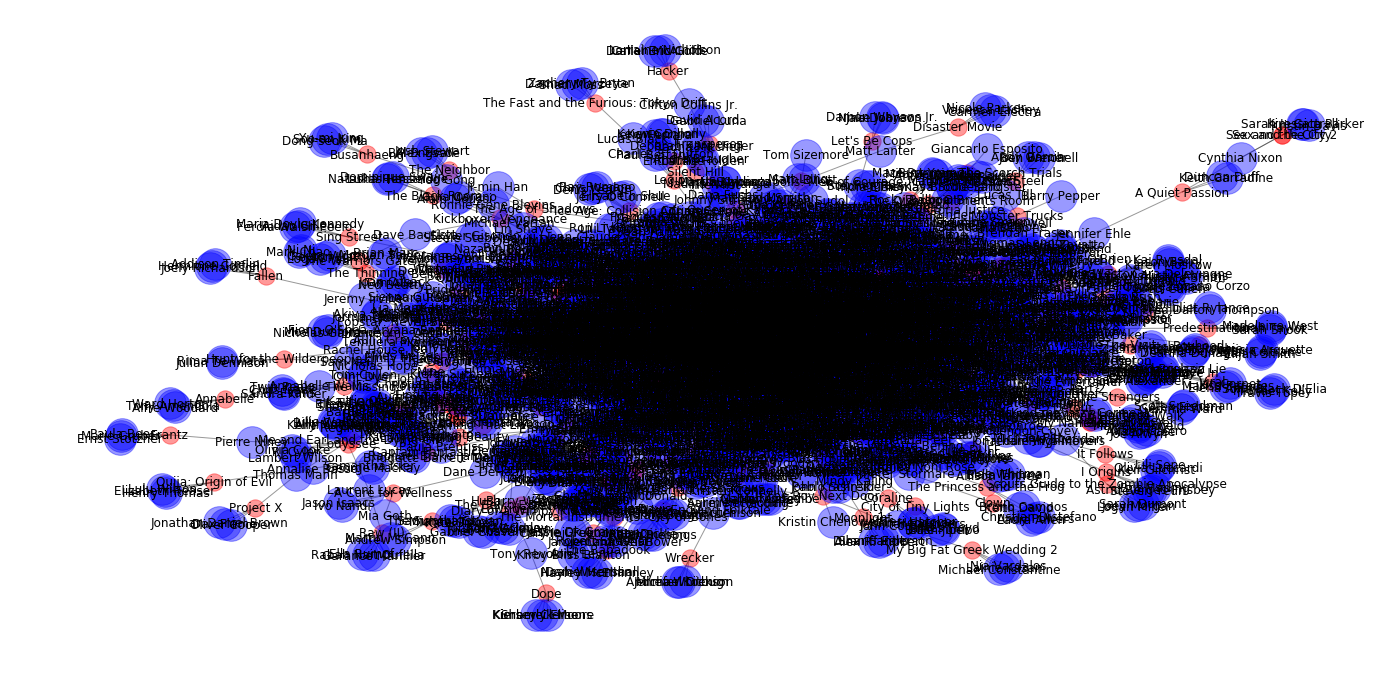

In [24]:
# Visualize the 2-mode networks
Titles, Actors = nx.bipartite.sets(G)
plt.rcParams["figure.figsize"] = (24,12)
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=Titles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(G, pos, nodelist=Actors, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(G, pos, alpha = 0.4)
nx.draw_networkx_labels(G, pos)

This won't win any beauty contests - we'll visualize a selection later. But the outlying nodes in the connected network we can see make sense. The Babadook in the lower right-hand corner is a well-received Australian horror movie featuring a cast likely not seen in many other movies popular with the US-centric IMDB audience.

Let's run some quick distance metrics. Of our connected subgraph, the radius, or the minimum eccentricity, runs the distance from each node to all other nodes, and then returns the minimum measure of that. In other words, of all the nodes, what is the shortest distance between a node and all other nodes.

In [25]:
print('radius =', nx.radius(G))

radius = 11


Any nodes with eccentricities near the radius of a graph are likely in the center. We would guess that these would be either movies with large diverse (in terms of genre breadth) casts or actors who choose a wide variety or role types.

In [26]:
print('center =', nx.center(G))

center = ['Guardians of the Galaxy', 'Prometheus', 'Interstellar', 'Mad Max: Fury Road', 'Inglourious Basterds', 'The Wolf of Wall Street', 'Gone Girl', 'Avengers: Age of Ultron', 'The Departed', 'The Dark Knight Rises', 'Mamma Mia!', 'Into the Woods', 'No Country for Old Men', 'Shutter Island', 'Free Fire', 'Dawn of the Planet of the Apes', 'Spotlight', 'Iron Man', 'Old Boy', "The Huntsman: Winter's War", 'Jackie', 'Fury', 'Les Misérables', 'Zodiac', 'The Devil Wears Prada', 'In Time', 'Hail', 'Caesar!', 'Criminal', 'Wanted', 'Collide', 'Steve Jobs', 'Couples Retreat', 'Atonement', 'Filth', 'The Other Guys', 'American Gangster', 'The Book of Eli', 'Men in Black 3', 'Savages', 'Chappie', 'Elysium', 'A Good Year', 'Jack Reacher', 'Limitless', 'Fantastic Four', 'Snow White and the Huntsman', 'The Finest Hours', 'Moneyball', 'Sunshine', "Daddy's Home", 'Megamind', 'Anna Karenina', 'Pain & Gain', 'Child 44', 'Tinker Tailor Soldier Spy', 'Genius', 'The Hollars', 'Closed Circuit', 'Nymphoman

This checks out. We see movies instead of actors as our center nodes, which makes sense. And these are mostly bigger movies with large casts that either feature international actors or actors who are crossing genres.

The diameter, or the largest, of our connected subgraph, calculates the shortest path between the furthest away nodes in the graph. So this might be an Australian actor in the Babadook connected to a younger American actor who's only appeared in one movie on the other side of the subgraph.

In [27]:
print('diameter =', nx.diameter(G))

diameter = 18


Having calculated measures of distance, let's look at some centrality metrics. We'll use the process developed in Chapter 3 of our textbook.

In [28]:
def sortSecond(val):
    return val[1]

In [29]:
#create function to retrieve sorted degree list
#ch 3 p. 47 of textbook
#plus internet searches to adapt for ch 3
from operator import itemgetter as ig

def sorted_map(map):
    ms = sorted(map.items(), key=ig(1), reverse=True)
    return ms

In [30]:
d=dict(G.degree())
ds=sorted_map(d)
ds[:10]

[('Mark Wahlberg', 15),
 ('Hugh Jackman', 14),
 ('Christian Bale', 13),
 ('Brad Pitt', 13),
 ('Michael Fassbender', 12),
 ('Scarlett Johansson', 12),
 ('Ryan Gosling', 12),
 ('Emma Stone', 12),
 ('Anne Hathaway', 12),
 ('Robert Downey Jr.', 12)]

Degrees here simply captures the number of times a node appears in the dataset. So Wahlberg's in the most of the top 1000 movies from 2006-2016. Between bad action movies and some suprise hit comedies, this makes sense. Movies would show up here only if they had larger casts included in the dataset.

In [31]:
c=nx.closeness_centrality(G)
cs=sorted_map(c)
cs[:10]

[('Christian Bale', 0.17806247300993233),
 ('Mark Wahlberg', 0.172404181184669),
 ('Brad Pitt', 0.17156726768377253),
 ('Charlize Theron', 0.16942884536364883),
 ('Hugh Jackman', 0.16919710025988238),
 ('Matt Damon', 0.16864349011588275),
 ('Leonardo DiCaprio', 0.16850565318076557),
 ('Anna Kendrick', 0.16827642497619372),
 ('The Dark Knight Rises', 0.16803640562385383),
 ('Michael Fassbender', 0.16786538200569956)]

Closeness centrality measures a node's ability to communicate with others. In our book's exmaple, these are the gossip mongers. 

From a movie industry perspective, this would be a node's ability to reach all other nodes in the network with fewest edges. Notice that, whereas our distance measure of centers highlighted mostly movies, here we get almost all actors.

In [32]:
b=nx.betweenness_centrality(G)
bs=sorted_map(b)
bs[:10]

[('Mark Wahlberg', 0.042193116733958244),
 ('Christian Bale', 0.038022735167341615),
 ('Channing Tatum', 0.03391862711228865),
 ('Hugh Jackman', 0.03183830856383147),
 ('Charlize Theron', 0.028704173024282062),
 ('Brad Pitt', 0.027683278966693006),
 ('Tom Hardy', 0.025643091428860478),
 ('Matthew McConaughey', 0.025445461670917557),
 ('Sharlto Copley', 0.02462683278891274),
 ('Anne Hathaway', 0.02438752430474505)]

Betweeness centrality, according to our textbook, is based on the idea that power resides in bottlenecks between networks. So a cross-genre actor like Hugh Jackman who appears in action films, musicals, and romantic comedies might be an important connector to different groups of actors.

Summing our centrality measures up:

In [33]:
#from pg. 54

names1=[x[0] for x in ds[:10]]
names2=[x[0] for x in cs[:10]]
names3=[x[0] for x in bs[:10]]

names=list(set(names1) | set(names2) | set(names3))
table=[[name,d[name],c[name],b[name]] for name in names]
print(pd.DataFrame(table))

                        0   1         2         3
0   The Dark Knight Rises   4  0.168036  0.011149
1         Charlize Theron  10  0.169429  0.028704
2               Brad Pitt  13  0.171567  0.027683
3              Emma Stone  12  0.156167  0.017697
4            Hugh Jackman  14  0.169197  0.031838
5          Sharlto Copley   9  0.166869  0.024627
6          Christian Bale  13  0.178062  0.038023
7       Robert Downey Jr.  12  0.158793  0.013046
8              Matt Damon  10  0.168643  0.017123
9            Ryan Gosling  12  0.160026  0.017143
10     Scarlett Johansson  12  0.165374  0.018906
11          Anne Hathaway  12  0.167820  0.024388
12     Michael Fassbender  12  0.167865  0.022847
13      Leonardo DiCaprio  10  0.168506  0.019885
14         Channing Tatum  12  0.160462  0.033919
15              Tom Hardy  12  0.165021  0.025643
16    Matthew McConaughey  10  0.166375  0.025445
17          Anna Kendrick  11  0.168276  0.021553
18          Mark Wahlberg  15  0.172404  0.042193


The odd-man out here is probably Sharlto Copley, but a quick glance at his IMDB page reveals why his weird resume makes him a connector between a wide variety of actors.

Now let's look at eigenvector measurements, a metric that captures degree centrality. This looks to detect what the book calls "gray cardinals" by weighting connections to well-connected nodes more than the less ones.

In [34]:
e=nx.eigenvector_centrality_numpy(G)
es=sorted_map(e)
es[:10]

[('Steve Carell', 0.30967516483386043),
 ('Ryan Gosling', 0.26621757911556115),
 ('Emma Stone', 0.24162543342309606),
 ('Crazy', 0.1902775922309534),
 ('Stupid', 0.1902775922309534),
 ('Love.', 0.1902775922309534),
 ('The Big Short', 0.16589684249180078),
 ('Christian Bale', 0.15333277115081287),
 ('Julianne Moore', 0.14821035290109408),
 ('Jennifer Garner', 0.14073946971474216)]

Here we see a possible issue with our data import - the commas in the title of the movie Crazy, Stupid, Love led to duplicate records for that movie and likely cause the cast to have overrrated measures here. 

Let's separate the modes.

In [35]:
#create network only containing actors
G_act = bipartite.projected_graph(G, Actors)
nx.is_connected(G_act)

True

In [36]:
print(nx.info(G_act))

Name: 
Type: Graph
Number of nodes: 1575
Number of edges: 5151
Average degree:   6.5410


In [37]:
list(G_act.edges())[:10]

[('Aaron Paul', 'Chiwetel Ejiofor'),
 ('Aaron Paul', 'Jamie Dornan'),
 ('Aaron Paul', 'Scott Mescudi'),
 ('Aaron Paul', 'Alan Rickman'),
 ('Aaron Paul', 'Dominic Cooper'),
 ('Aaron Paul', 'Helen Mirren'),
 ('Aaron Paul', 'Sarah Gadon'),
 ('Aaron Paul', 'Barkhad Abdi'),
 ('Aaron Paul', 'Imogen Poots'),
 ('Aaron Paul', 'Casey Affleck')]

We see what we'd expect - the edges now are between actors in the same movie rather than actors and movies in which they star.

We will now look at groupings, first using the built-in find_cliques function and then using the island method described in the book.

In [38]:
list(nx.find_cliques(G_act))[:60]

[['Aaron Paul', 'Chiwetel Ejiofor', 'Casey Affleck', 'Anthony Mackie'],
 ['Aaron Paul', 'Jamie Dornan', 'Aiden Longworth', 'Sarah Gadon'],
 ['Aaron Paul', 'Alan Rickman', 'Helen Mirren', 'Barkhad Abdi'],
 ['Aaron Paul', 'Dominic Cooper', 'Sarah Gadon'],
 ['Aaron Paul', 'Dominic Cooper', 'Scott Mescudi', 'Imogen Poots'],
 ['Alison Pill', 'Mary Elizabeth Winstead', 'Michael Cera', 'Kieran Culkin'],
 ['Anika Noni Rose', 'Chiwetel Ejiofor', 'Thandie Newton', 'Joseph Mawle'],
 ['Anika Noni Rose', 'Keith David', 'Oprah Winfrey', 'Bruno Campos'],
 ['Duan Sanderson', 'Shariff Earp', 'Alex R. Hibbert', 'Mahershala Ali'],
 ['Andy Samberg', 'Adam Sandler', 'Selena Gomez', 'Kevin James'],
 ['Andy Samberg', 'Adam Sandler', 'Jennifer Aniston'],
 ['Andy Samberg', 'Katie Crown', 'Kelsey Grammer', 'Jennifer Aniston'],
 ['Andy Samberg', 'Akiva Schaffer', 'Jorma Taccone', 'Sarah Silverman'],
 ['Angela Bassett', 'Gerard Butler', 'Aaron Eckhart', 'Morgan Freeman'],
 ['Wendy Crewson', 'Sean Bridgers', 'Brie

Much of these cliques are just the casts listed for a film. Let's use the book's methodlogy to find some true islands. Beyond a degree, will we just see the casts of franchise films, or might we see director-specific cliques?

As a reminder, our starting dataset for analysis is itself as subgraph, so we've already "raised the water" slightly.

In [136]:
#pg. 64 book revised to trim nodes based on degree centrality
    
def trim_nodes(g, degree=1):
    g2=g.copy() #copy graph so that original is not altered adn to avoid error below
    for (node, val) in g.degree(): #must be run on original graph or dictionary will change size during iteration
            if val < degree:
                g2.remove_node(node)
    return g2


In [204]:
#pg. 64 book revised to trim nodes based on degree centrality, return df with additional into

def degree_island_method(g, iterations=5):

    degree = [val for (node, val) in g.degree()]
    
    mn=int(min(degree))
    mx=int(max(degree))
    step=int((mx-mn)/(iterations))
    island_list = [[deg_threshold, trim_nodes(g, deg_threshold)] for deg_threshold in range(mn,mx,step)]
    
    for item in island_list:
        num_nodes = len(item[1])
        item.append(num_nodes)
        num_subgraphs = len(list(nx.connected_component_subgraphs(item[1])))
        item.append(num_subgraphs)
    
    df = pd.DataFrame(island_list, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])
    print(df)
    return df

#Note: Without further modification, this may return unconnected nodes for the bipartite graph

In [205]:
df = degree_island_method(G_act)

   Degree Threshold                                              Graph  \
0                 2  (Aaron Paul, Alison Pill, Andy Samberg, Angela...   
1                10  (Aaron Paul, Meryl Streep, Cameron Diaz, Logan...   
2                18  (Anna Kendrick, Amy Adams, Keira Knightley, Re...   
3                26  (Anna Kendrick, Charlize Theron, Shia LaBeouf,...   
4                34  (Mark Wahlberg, Brad Pitt, Hugh Jackman, Chris...   

   Number of Nodes  Number of Subgraphs  
0             1575                    1  
1              274                    1  
2              112                    3  
3               38                    2  
4                4                    1  


In [188]:
df = pd.DataFrame(island_list, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])
print(df)

   Degree Threshold                                              Graph  \
0                 2  (Aaron Paul, Alison Pill, Andy Samberg, Angela...   
1                10  (Aaron Paul, Meryl Streep, Cameron Diaz, Logan...   
2                18  (Anna Kendrick, Amy Adams, Keira Knightley, Re...   
3                26  (Anna Kendrick, Charlize Theron, Shia LaBeouf,...   
4                34  (Mark Wahlberg, Brad Pitt, Hugh Jackman, Chris...   

   Number of Nodes  Number of Subgraphs  
0             1575                    1  
1              274                    1  
2              112                    3  
3               38                    2  
4                4                    1  


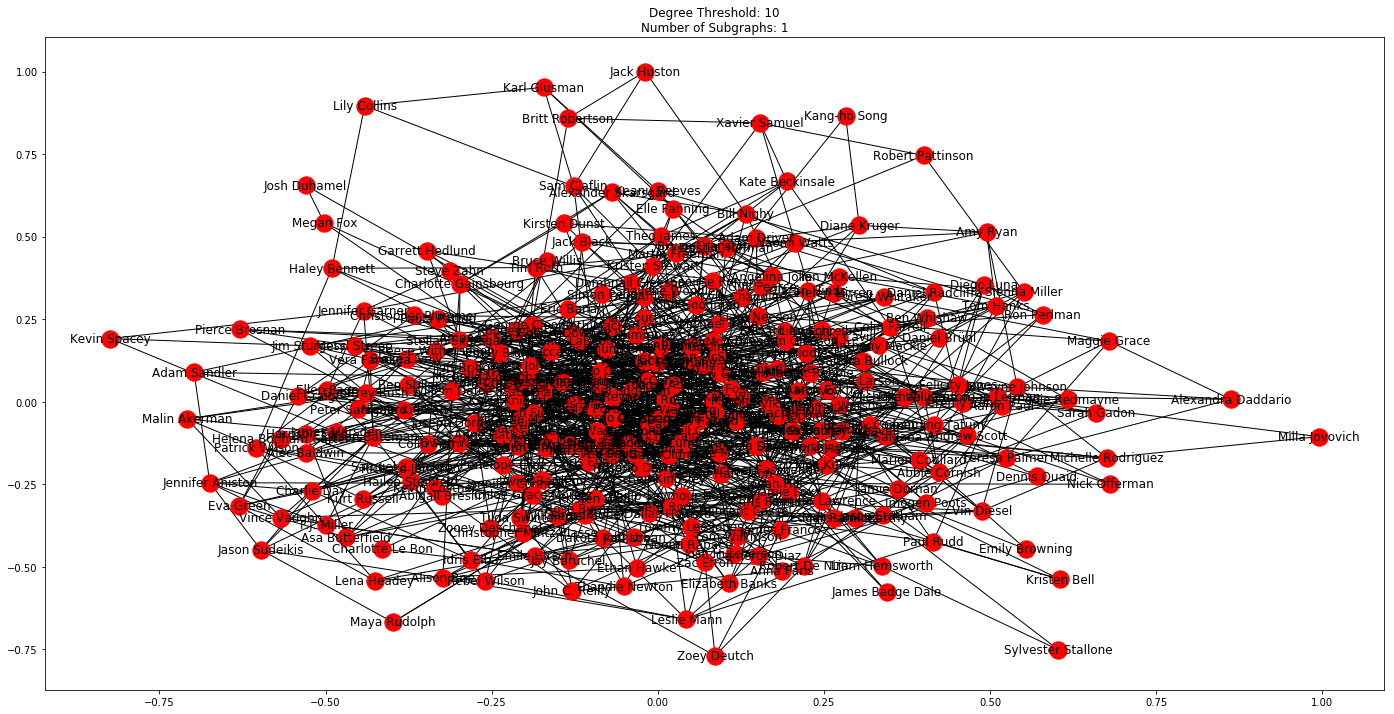

In [203]:
i = 1
G1 = df['Graph'][i]
pos = nx.spring_layout(G1)
title = str("Degree Threshold: %s\nNumber of Subgraphs: %s" % (df['Degree Threshold'][i], df['Number of Subgraphs'][i]))
plt.title(title)
nx.draw_networkx(G1)

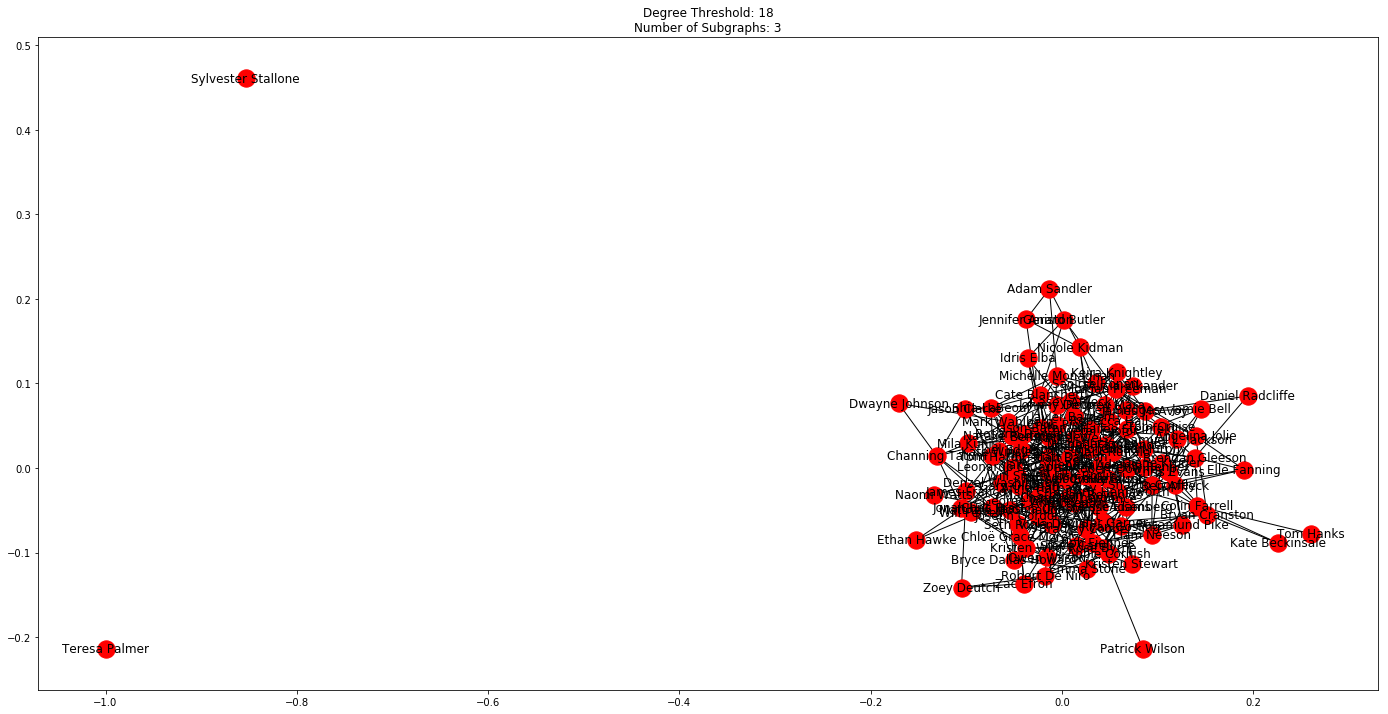

In [200]:
i = 2
G2 = df['Graph'][i]
pos = nx.spring_layout(G2)
title = str("Degree Threshold: %s\nNumber of Subgraphs: %s" % (df['Degree Threshold'][i], df['Number of Subgraphs'][i]))
plt.title(title)
nx.draw_networkx(G2)

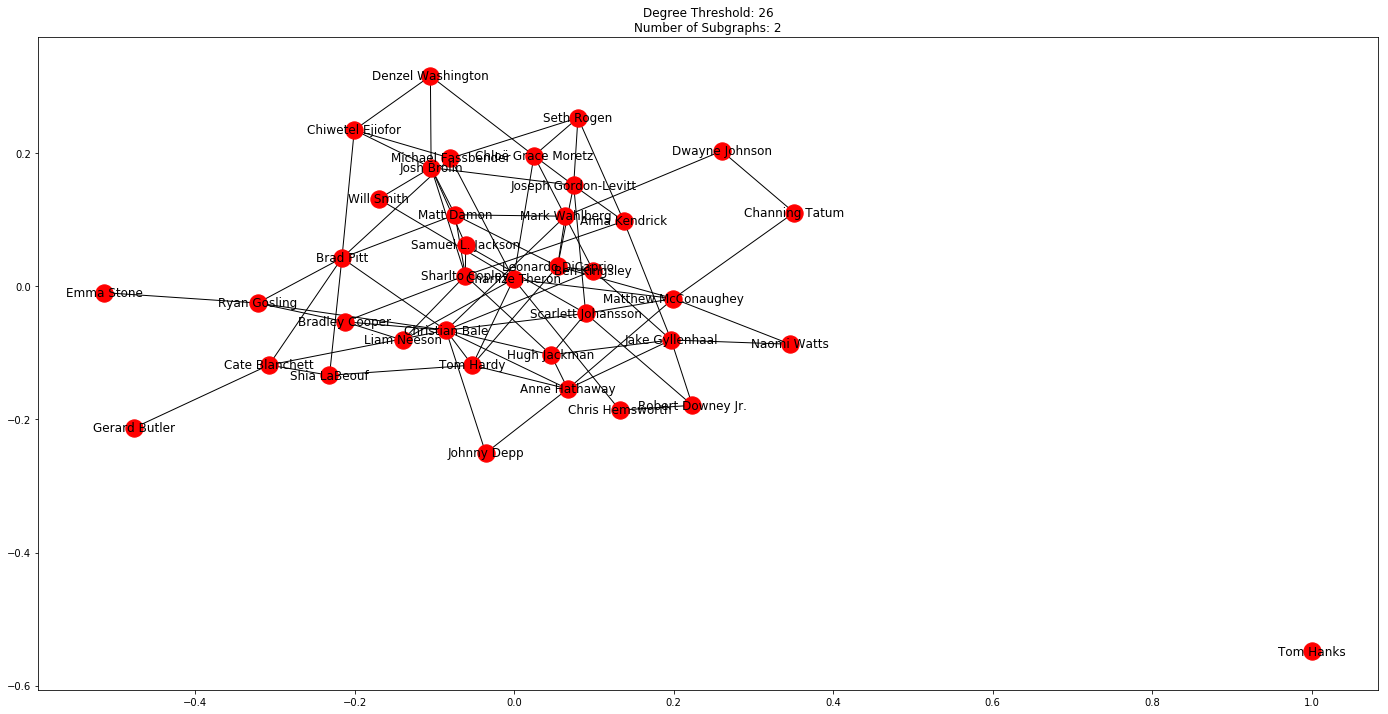

In [202]:
i = 3
G3 = df['Graph'][i]
pos = nx.spring_layout(G3)
title = str("Degree Threshold: %s\nNumber of Subgraphs: %s" % (df['Degree Threshold'][i], df['Number of Subgraphs'][i]))
plt.title(title)
nx.draw_networkx(G3)

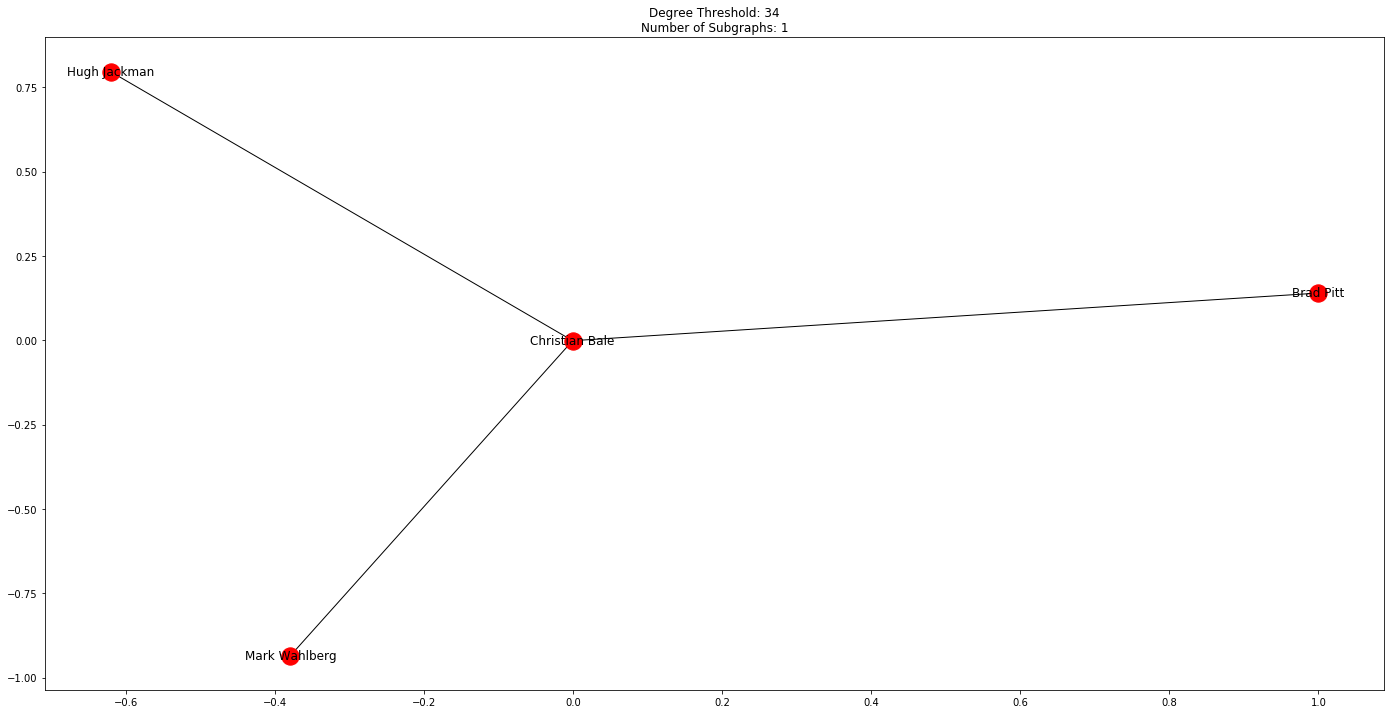

In [201]:
i = 4
G4 = df['Graph'][i]
pos = nx.spring_layout(G4)
title = str("Degree Threshold: %s\nNumber of Subgraphs: %s" % (df['Degree Threshold'][i], df['Number of Subgraphs'][i]))
plt.title(title)
nx.draw_networkx(G4)

Wow! These 3 guys have been in a *lot* of movies with Christian Bale!

### Conclusion


DegreeView({'Guardians of the Galaxy': 4, 'Chris Pratt': 7, 'Vin Diesel': 7, 'Bradley Cooper': 11, 'Zoe Saldana': 6, 'Prometheus': 4, 'Noomi Rapace': 5, 'Logan Marshall-Green': 2, 'Michael Fassbender': 12, 'Charlize Theron': 10, 'Split': 4, 'James McAvoy': 9, 'Anya Taylor-Joy': 3, 'Haley Lu Richardson': 2, 'Jessica Sula': 1, 'Sing': 4, 'Matthew McConaughey': 10, 'Reese Witherspoon': 4, 'Seth MacFarlane': 4, 'Scarlett Johansson': 12, 'Suicide Squad': 4, 'Will Smith': 10, 'Jared Leto': 3, 'Margot Robbie': 5, 'Viola Davis': 7, 'The Great Wall': 4, 'Matt Damon': 10, 'Tian Jing': 1, 'Willem Dafoe': 6, 'Andy Lau': 1, 'La La Land': 4, 'Ryan Gosling': 12, 'Emma Stone': 12, 'Rosemarie DeWitt': 1, 'J.K. Simmons': 5, 'Mindhorn': 4, 'Essie Davis': 2, 'Andrea Riseborough': 3, 'Julian Barratt': 1, 'Kenneth Branagh': 2, 'The Lost City of Z': 4, 'Charlie Hunnam': 3, 'Robert Pattinson': 6, 'Sienna Miller': 5, 'Tom Holland': 2, 'Passengers': 4, 'Jennifer Lawrence': 11, 'Michael Sheen': 3, 'Laurence Fish